In [1]:
# 그래픽 카드 둘로 쓰기 (두개 있을때, 하나만 있다면 0)
# gpu idx 를 0 또는 1 로 설정하시오
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] ="{}".format(1) # gpu idx

In [2]:
# 경로에 폴더가 없으면 폴더 만들기
import os

def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [3]:
import numpy as np
import itertools
import pickle

import pathlib

import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image
import PIL

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm

EPOCH = 100
KERNEL_SIZE = 3
BATCH_SIZE = 128
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

DATA_PATH = "./MIT_DATA_png/graph_data/"

def list_to_list(input_list):
    input_list_to_list = list(itertools.chain(*input_list))
    return input_list_to_list

# 데이터 불러오기

In [4]:
data_dir = pathlib.Path(DATA_PATH)
print(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

f = list(data_dir.glob('F/*'))
n = list(data_dir.glob('N/*'))
q = list(data_dir.glob('Q/*'))
s = list(data_dir.glob('S/*'))
v = list(data_dir.glob('V/*'))

MIT_DATA_png\graph_data
112599


# 데이터 split
## train, test, validation data 나누기

In [5]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode='int',
    color_mode='grayscale',
    seed=42,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 112599 files belonging to 5 classes.
Using 90080 files for training.


In [6]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode='int',
    color_mode='grayscale',
    seed=42,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 112599 files belonging to 5 classes.
Using 22519 files for validation.


<bound method DatasetV2.unique of <BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>
<bound method DatasetV2.unique of <BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>
['F', 'N', 'Q', 'S', 'V']


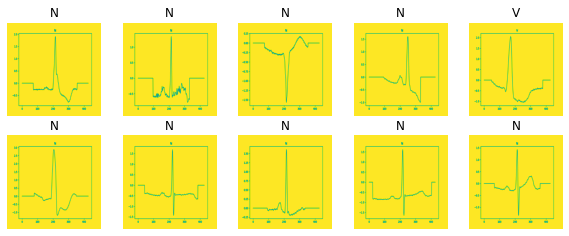

In [7]:
print(train_ds.unique)
print(val_ds.unique)

class_names = train_ds.class_names
print(class_names)
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# 모델 생성

In [8]:
input_size = (512, 512, 1)

models = keras.Sequential([
    # tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_size),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),

    layers.Conv2D(128, kernel_size=(2, 2), activation='relu', input_shape=input_size),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=input_size),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),

    layers.Conv2D(512, kernel_size=(2, 2), activation='relu', input_shape=input_size),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [9]:
models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 128)     32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 128)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 256)     295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 256)      0

In [10]:
models.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
)

### 콜백 설정

In [11]:
# 콜백 설정
from keras.callbacks import EarlyStopping, ModelCheckpoint

outDir = './cheakpoint/lefms_model/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{val_accuracy:.4f}.h5'
def get_callbacks(patience = 50):
    
    earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=patience)
  
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_accuracy', verbose=1, save_best_only=True, period = 1)
  
    # callbacks = [earlystop, model_checkpoint]     # earlystop 사용하고 싶으면 이거 풀고 아래꺼 주석 처리
    callbacks = [model_checkpoint]

    return callbacks

# 학습하기

In [12]:
callbacks = get_callbacks()

models_hist = models.fit(
    train_ds, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCH, 
    validation_data=(val_ds),
    callbacks = [callbacks]
)

Epoch 1/100


# 결과 시각화 하기

In [ ]:
# 학습 된 모델의 학습 과정 시각화
import matplotlib.pyplot as plt
def plot_model__hist(hist):
    path = './cheakpoint/lefms/' # loss, accuracy 그래프 저장할 path
    createDirectory(path)

    # loss 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend()
    plt.show()

    # accuracy 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend(loc = "lower right")
    plt.show()

In [ ]:
plot_model__hist(models_hist)
loss,acc = models.evaluate(val_ds, verbose=2)
print("multi_model의 정확도: {:5.2f}%".format(100*acc))
print("multi_model의 Loss: {}".format(loss))

# 모델 불러와서 confusion matrix 그리기

In [ ]:
# 모델 불러오기
reconstructed_model = keras.models.load_model("./cheakpoint/lefms_model/weights-0.9924.h5")

In [ ]:
# 예측값 얻기
y_pred = reconstructed_model.predict(X_test)

In [ ]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y= []
for val in y_test:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y.append(cnt)

In [ ]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y_pred = []
for val in y_pred:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y_pred.append(cnt)

In [ ]:
# 최종 정확도 산출
score = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])

### confusion matrix 그리기

In [ ]:
# 개수 버전
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

cm2 = confusion_matrix(new_y, new_y_pred)
sns.heatmap(cm2, annot = True, fmt = 'd', cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

In [ ]:
# percentile 버전
total = np.sum(cm2, axis=1)
cm2_percentile = cm2/total[:,None]
sns.heatmap(np.round(cm2_percentile,3), annot = True, cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y, new_y_pred)

In [ ]:
# classification_report 그리기
from sklearn.metrics import classification_report
target_names = ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q']
print(classification_report(new_y, new_y_pred, target_names=target_names))